In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)

randomState = 42

In [36]:
df = pd.read_csv('project1.csv')

print(list(df.columns))

df.columns = [str(c).strip() for c in df.columns]

# The column renaming fix was adapted from AI assistance when resolving KeyError issues; see [5]
renameMap = {}
for c in df.columns:
    key = c.replace('_', ' ').replace('-', ' ').strip().lower()

    if key == 'ageuponoutcome' or key == 'age upon outcome':
        renameMap[c] = 'Age Upon Outcome'
    elif key == 'sex upon outcome' or key == 'sexuponoutcome':
        renameMap[c] = 'Sex Upon Outcome'
    elif key == 'outcome subtype' or key == 'outcome_subtype':
        renameMap[c] = 'Outcome Subtype'
    elif key == 'animal type' or key == 'animal_type':
        renameMap[c] = 'Animal Type'
    elif key == 'outcome type' or key == 'outcometype':
        renameMap[c] = 'OutcomeType'
    elif key == 'date time' or key == 'datetime':
        renameMap[c] = 'DateTime'
    elif key == 'monthyear' or key == 'month year':
        renameMap[c] = 'MonthYear'
    elif key == 'animal id' or key == 'animalid':
        renameMap[c] = 'AnimalID'
    elif key == 'date of birth' or key == 'dateofbirth' or key == 'dob':
        renameMap[c] = 'Date of Birth'
    elif key == 'color':
        renameMap[c] = 'Color'
    elif key == 'breed':
        renameMap[c] = 'Breed'
    elif key == 'name':
        renameMap[c] = 'Name'

df = df.rename(columns=renameMap)

print(list(df.columns))

print('Shape:', df.shape)
df.head()

['Animal ID', 'Date of Birth', 'Name', 'DateTime', 'MonthYear', 'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color']
['AnimalID', 'Date of Birth', 'Name', 'DateTime', 'MonthYear', 'OutcomeType', 'Outcome Subtype', 'Animal Type', 'Sex Upon Outcome', 'Age Upon Outcome', 'Breed', 'Color']
Shape: (131165, 12)


,AnimalID,Date of Birth,Name,DateTime,MonthYear,OutcomeType,Outcome Subtype,Animal Type,Sex Upon Outcome,Age Upon Outcome,Breed,Color
0,A680855,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
1,A680857,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
2,A680858,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
3,A680859,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
4,A680860,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


In [37]:
print(df.dtypes)
dupCount = df.duplicated().sum()
print('Duplicate rows:', dupCount)
if dupCount > 0:
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    print('Duplicates dropped. New shape:', df.shape)

AnimalID            object
Date of Birth       object
Name                object
DateTime            object
MonthYear           object
OutcomeType         object
Outcome Subtype     object
Animal Type         object
Sex Upon Outcome    object
Age Upon Outcome    object
Breed               object
Color               object
dtype: object
Duplicate rows: 17
Duplicates dropped. New shape: (131148, 12)


In [38]:
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls.to_frame('null_count'))

,null_count
Outcome Subtype,65346
Name,37503
OutcomeType,40
AnimalID,0
Date of Birth,0
DateTime,0
MonthYear,0
Animal Type,0
Sex Upon Outcome,0
Age Upon Outcome,0


In [39]:
import re

# The code below was developed with AI assistance to convert text-based ages to days; see [1].
def parse_age_to_days(text):
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower()
    m = re.match(r'\s*(\d+(?:\.\d+)?)\s*(year|years|yr|yrs|month|months|mo|mos|week|weeks|wk|wks|day|days)\s*', s)
    if m is None:
        return np.nan
    val = float(m.group(1))
    unit = m.group(2)
    days = np.nan
    if unit.startswith('year') or unit in {'yr','yrs'}:
        days = val * 365.0
    elif unit.startswith('month') or unit in {'mo','mos'}:
        days = val * 30.0
    elif unit.startswith('week') or unit in {'wk','wks'}:
        days = val * 7.0
    elif unit.startswith('day'):
        days = val
    return days

# Function design was guided by AI discussion on parsing gender and fixed status; see [2].
def split_sex_upon_outcome(text):
    if pd.isna(text):
        return 'Unknown', 0
    s = str(text).strip().title()
    sex = 'Unknown'
    if 'Male' in s:
        sex = 'Male'
    elif 'Female' in s:
        sex = 'Female'
    fixed = 0
    if 'Neutered' in s or 'Spayed' in s:
        fixed = 1
    elif 'Intact' in s:
        fixed = 0
    return sex, fixed

def base_color(text):
    if pd.isna(text):
        return np.nan
    first_part = str(text).split('/')[0]
    first_word = first_part.split()[0]
    return first_word.title()

nulls_before = df.isna().sum().sort_values(ascending=False)
display(nulls_before.to_frame('null_count_before'))

df['ageDays'] = df['Age Upon Outcome'].apply(parse_age_to_days)
# Applying helper function created with AI guidance; see [2].
sex_fixed = df['Sex Upon Outcome'].apply(split_sex_upon_outcome)
df['sexSimple'] = sex_fixed.apply(lambda t: t[0])
df['isFixed'] = sex_fixed.apply(lambda t: t[1]).astype('Int64')
df['baseColor'] = df['Color'].apply(base_color)

ageMedian = df['ageDays'].median(skipna=True)
df['ageDays'] = df['ageDays'].fillna(ageMedian)

fillCols = ['sexSimple','baseColor','Animal Type','Breed','Outcome Subtype','OutcomeType']
for col in fillCols:
    if col in df.columns:
        modeSeries = df[col].mode(dropna=True)
        if len(modeSeries) > 0:
            modeVal = modeSeries.iloc[0]
        else:
            modeVal = 'Unknown'
        df[col] = df[col].fillna(modeVal)

nulls_after = df.isna().sum().sort_values(ascending=False)
display(nulls_after.to_frame('null_count_after'))

,null_count_before
Outcome Subtype,65346
Name,37503
OutcomeType,40
AnimalID,0
Date of Birth,0
DateTime,0
MonthYear,0
Animal Type,0
Sex Upon Outcome,0
Age Upon Outcome,0


,null_count_after
Name,37503
AnimalID,0
Date of Birth,0
DateTime,0
MonthYear,0
OutcomeType,0
Outcome Subtype,0
Animal Type,0
Sex Upon Outcome,0
Age Upon Outcome,0


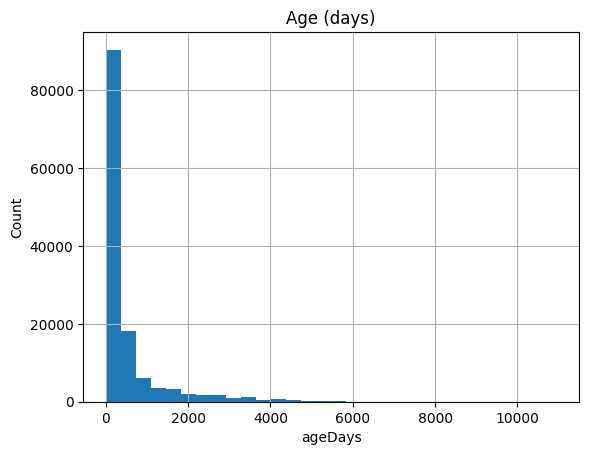

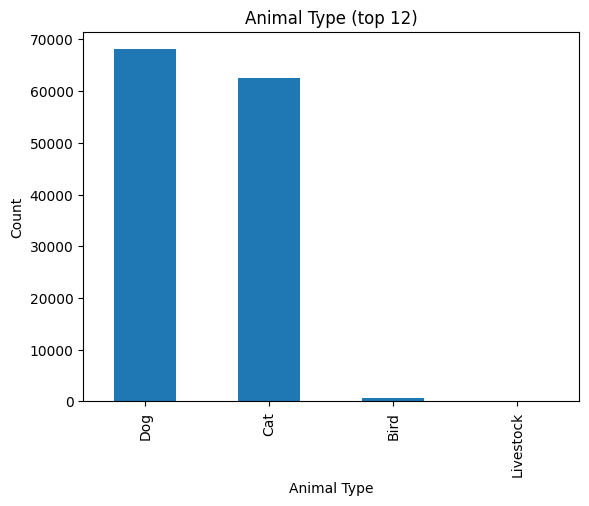

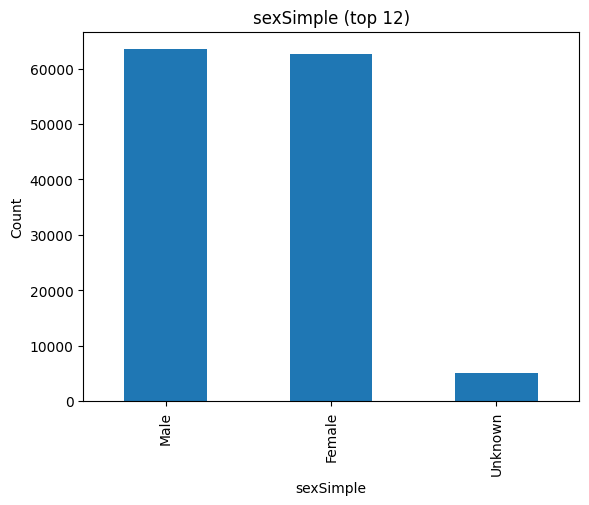

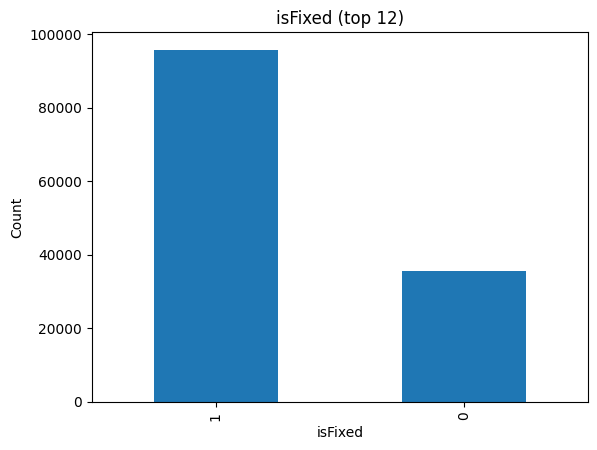

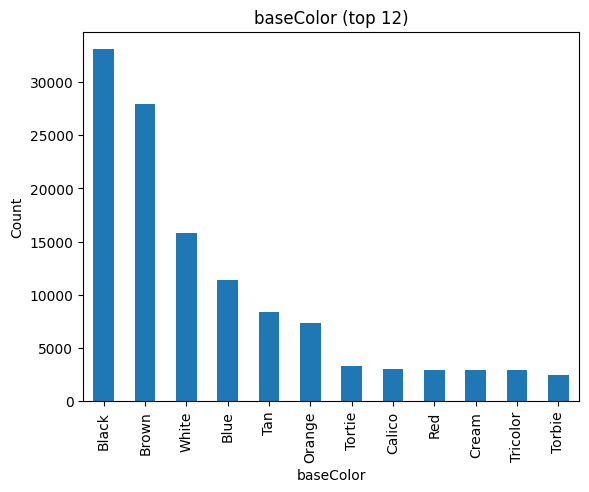

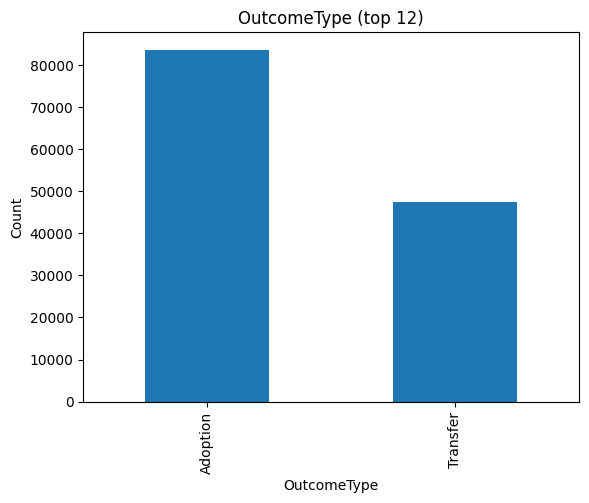

In [40]:
plt.figure()
df['ageDays'].hist(bins=30)
plt.title('Age (days)')
plt.xlabel('ageDays')
plt.ylabel('Count')
plt.show()

colsToPlot = ['Animal Type','sexSimple','isFixed','baseColor','OutcomeType']
for col in colsToPlot:
    plt.figure()
    df[col].value_counts().head(12).plot(kind='bar')
    plt.title(col + ' (top 12)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [41]:
irrelevant = ['Name','AnimalID','DateTime','MonthYear','Outcome Subtype','Color']
to_drop = []
for c in irrelevant:
    if c in df.columns:
        to_drop.append(c)
dfModel = df.drop(columns=to_drop).copy()
dfModel.head()

,Date of Birth,OutcomeType,Animal Type,Sex Upon Outcome,Age Upon Outcome,Breed,ageDays,sexSimple,isFixed,baseColor
0,5/25/14,Transfer,Bird,Unknown,2 weeks,Duck,14.0,Unknown,0,Yellow
1,5/25/14,Transfer,Bird,Unknown,2 weeks,Duck,14.0,Unknown,0,Yellow
2,5/25/14,Transfer,Bird,Unknown,2 weeks,Duck,14.0,Unknown,0,Yellow
3,5/25/14,Transfer,Bird,Unknown,2 weeks,Duck,14.0,Unknown,0,Yellow
4,5/25/14,Transfer,Bird,Unknown,2 weeks,Duck,14.0,Unknown,0,Yellow


In [42]:
dfModel['ageDays'] = pd.to_numeric(dfModel['ageDays'], errors='coerce')

catCols = []
for c in dfModel.columns:
    if dfModel[c].dtype == 'object' and c != 'OutcomeType':
        catCols.append(c)
for c in catCols:
    dfModel[c] = dfModel[c].astype('category')
dfModel.dtypes

Date of Birth       category
OutcomeType           object
Animal Type         category
Sex Upon Outcome    category
Age Upon Outcome    category
Breed               category
ageDays              float64
sexSimple           category
isFixed                Int64
baseColor           category
dtype: object

In [43]:
demoDf = dfModel.copy()
X_demo = demoDf.drop(columns=['OutcomeType'])
y_demo = demoDf['OutcomeType']

demoCatCols = []
for c in X_demo.columns:
    if str(X_demo[c].dtype) == 'category':
        demoCatCols.append(c)

demoEncoded = pd.get_dummies(X_demo, columns=demoCatCols, drop_first=False)
print('Encoded shape:', demoEncoded.shape)
demoEncoded.head(3)

Encoded shape: (131148, 10380)


,ageDays,isFixed,Date of Birth_1/1/02,Date of Birth_1/1/04,Date of Birth_1/1/06,Date of Birth_1/1/07,Date of Birth_1/1/08,Date of Birth_1/1/09,Date of Birth_1/1/10,Date of Birth_1/1/11,Date of Birth_1/1/12,Date of Birth_1/1/13,Date of Birth_1/1/14,Date of Birth_1/1/15,Date of Birth_1/1/16,Date of Birth_1/1/17,Date of Birth_1/1/18,Date of Birth_1/1/19,Date of Birth_1/1/20,Date of Birth_1/1/21,Date of Birth_1/1/22,Date of Birth_1/1/23,Date of Birth_1/1/24,Date of Birth_1/1/25,Date of Birth_1/10/01,Date of Birth_1/10/04,Date of Birth_1/10/05,Date of Birth_1/10/06,Date of Birth_1/10/07,Date of Birth_1/10/08,Date of Birth_1/10/09,Date of Birth_1/10/10,Date of Birth_1/10/11,Date of Birth_1/10/12,Date of Birth_1/10/13,Date of Birth_1/10/14,Date of Birth_1/10/15,Date of Birth_1/10/16,Date of Birth_1/10/17,Date of Birth_1/10/18,Date of Birth_1/10/19,Date of Birth_1/10/20,Date of Birth_1/10/21,Date of Birth_1/10/22,Date of Birth_1/10/23,Date of Birth_1/10/24,Date of Birth_1/10/25,Date of Birth_1/11/04,Date of Birth_1/11/05,Date of Birth_1/11/06,Date of Birth_1/11/07,Date of Birth_1/11/08,Date of Birth_1/11/09,Date of Birth_1/11/10,Date of Birth_1/11/11,Date of Birth_1/11/12,Date of Birth_1/11/13,Date of Birth_1/11/14,Date of Birth_1/11/15,Date of Birth_1/11/16,...,Breed_Yorkshire Terrier Mix,Breed_Yorkshire Terrier/Australian Terrier,Breed_Yorkshire Terrier/Border Terrier,Breed_Yorkshire Terrier/Bruss Griffon,Breed_Yorkshire Terrier/Cairn Terrier,Breed_Yorkshire Terrier/Chihuahua Longhair,Breed_Yorkshire Terrier/Chihuahua Shorthair,Breed_Yorkshire Terrier/Chinese Crested,Breed_Yorkshire Terrier/Dachshund,Breed_Yorkshire Terrier/Dachshund Longhair,Breed_Yorkshire Terrier/Dachshund Wirehair,Breed_Yorkshire Terrier/Havanese,Breed_Yorkshire Terrier/Lhasa Apso,Breed_Yorkshire Terrier/Maltese,Breed_Yorkshire Terrier/Miniature Poodle,Breed_Yorkshire Terrier/Miniature Schnauzer,Breed_Yorkshire Terrier/Norfolk Terrier,Breed_Yorkshire Terrier/Parson Russell Terrier,Breed_Yorkshire Terrier/Pomeranian,Breed_Yorkshire Terrier/Rat Terrier,Breed_Yorkshire Terrier/Scottish Terrier,Breed_Yorkshire Terrier/Shih Tzu,Breed_Yorkshire Terrier/Soft Coated Wheaten Terrier,Breed_Yorkshire Terrier/Standard Poodle,Breed_Yorkshire Terrier/Standard Schnauzer,Breed_Yorkshire Terrier/Toy Poodle,Breed_Yorkshire Terrier/Yorkshire Terrier,sexSimple_Female,sexSimple_Male,sexSimple_Unknown,baseColor_Agouti,baseColor_Apricot,baseColor_Black,baseColor_Blue,baseColor_Brown,baseColor_Buff,baseColor_Calico,baseColor_Chocolate,baseColor_Cream,baseColor_Fawn,baseColor_Flame,baseColor_Gold,baseColor_Gray,baseColor_Green,baseColor_Lilac,baseColor_Liver,baseColor_Lynx,baseColor_Orange,baseColor_Pink,baseColor_Red,baseColor_Ruddy,baseColor_Sable,baseColor_Seal,baseColor_Silver,baseColor_Tan,baseColor_Torbie,baseColor_Tortie,baseColor_Tricolor,baseColor_White,baseColor_Yellow
0,14.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,14.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,F

In [44]:
# Part 1 finished

In [45]:
# Part 2

In [46]:
if 'Breed' in dfModel.columns:
    dfClf = dfModel.drop(columns=['Breed'])
else:
    dfClf = dfModel.copy()

X = dfClf.drop(columns=['OutcomeType'])
y = dfClf['OutcomeType'].astype('category')

numericFeatures = ['ageDays','isFixed']
categoricalFeatures = []
for c in X.columns:
    if c not in numericFeatures:
        categoricalFeatures.append(c)

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numericFeatures),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalFeatures),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=randomState, stratify=y
)

print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (104918, 8)  Test: (26230, 8)


In [47]:
knnBase = Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier(n_neighbors=5))])
knnBase.fit(X_train, y_train)
y_pred_knn = knnBase.predict(X_test)

In [ ]:
# Full GridSearchCV run (not subsampled); initial runtime considerations discussed with AI; see [3].
knnGrid = Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier())])
paramGrid = {
    'clf__n_neighbors': [3,5,7,9,11,15],
    'clf__weights': ['uniform','distance'],
    'clf__p': [1,2]
}
grid = GridSearchCV(knnGrid, paramGrid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best KNN params:', grid.best_params_)
y_pred_knn_gs = grid.predict(X_test)

In [ ]:
logReg = Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=500))])
logReg.fit(X_train, y_train)
y_pred_lr = logReg.predict(X_test)

In [ ]:
# Choice of F1 score as main metric was clarified through AI discussion; see [4].
def build_results_table(y_true, preds_map):
    rows = []
    for name, preds in preds_map.items():
        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds, average='weighted', zero_division=0)
        rec = recall_score(y_true, preds, average='weighted', zero_division=0)
        f1 = f1_score(y_true, preds, average='weighted', zero_division=0)
        rows.append({'Model': name, 'Accuracy': acc, 'Precision (weighted)': prec, 'Recall (weighted)': rec, 'F1 (weighted)': f1})
    dfRes = pd.DataFrame(rows).sort_values('F1 (weighted)', ascending=False)
    return dfRes

resultsTable = build_results_table(y_test, {
    'KNN (k=5)': y_pred_knn,
    'KNN (GridSearchCV)': y_pred_knn_gs,
    'Logistic Regression': y_pred_lr
})
resultsTable

In [ ]:
print('Classification Report — KNN (k=5)')
print(classification_report(y_test, y_pred_knn, zero_division=0))

print('\nClassification Report — KNN (GridSearchCV)')
print(classification_report(y_test, y_pred_knn_gs, zero_division=0))

print('\nClassification Report — Logistic Regression')
print(classification_report(y_test, y_pred_lr, zero_division=0))

for name, preds in {
    'KNN (k=5)': y_pred_knn,
    'KNN (GridSearchCV)': y_pred_knn_gs,
    'Logistic Regression': y_pred_lr
}.items():
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title('Confusion Matrix — ' + name)
    plt.show()